*Hubert Kaczyński; nr albumu 331386; grupa 101*
# **WSI laboratorium 3. Algorytnm min-max.**

Poniżej znajdują się analizy przygotowanego przeze mnie algorytmu min-max z obcinaniem $ \alpha $ $ \beta $ na przykładzie gry w kółko i krzyżyk. Gra odbywa się na planszy $ NxN $ dla $ N $ z przedziału $ [3, 9] $.

## **Implementacja**

### **Symulacja gry**

Aby umożliwić algorytmowi wygodne symulowanie gry w kółko i krzyżyk, zaimplementowałem klasę Board, która przechowuje pola planszy w postaci tablicy tablic. Pozwala ona również na wykonanie ruchu, sprawdzenie, czy któraś ze stron wygrała oraz zwrócenie współrzędnych wszystkich pustych pól (oznaczonych "_").

In [20]:
import random
import time
import numpy as np
import matplotlib.pyplot as plt

class Board:
    def __init__(self, N):
        self.N = N
        self.board = [['_' for _ in range(N)] for _ in range(N)]

    def get_N(self):
        return self.N
    
    def get_board(self):
        return self.board
    
    def __str__(self):
        image = ''
        for row in self.board:
            image += ' '.join(row) + '\n'
        return image

    def play_turn(self, row_id, column_id, player_char):
        self.board[row_id][column_id] = player_char

    def check_results(self):
        # 0: O won; 1: X won; 2: tie; None: game still ongoing 
        for i in range(self.N):
            if all(self.board[i][j] == 'X' for j in range(self.N)):
                return 1
            if all(self.board[i][j] == 'O' for j in range(self.N)):
                return 0
        for j in range(self.N):
            if all(self.board[i][j] == 'X' for i in range(self.N)):
                return 1
            if all(self.board[i][j] == 'O' for i in range(self.N)):
                return 0
        if all(self.board[i][i] == 'X' for i in range(self.N)):
            return 1
        if all(self.board[i][i] == 'O' for i in range(self.N)):
            return 0
        if all(self.board[i][self.N-i-1] == 'X' for i in range(self.N)):
            return 1
        if all(self.board[i][self.N-i-1] == 'O' for i in range(self.N)):
            return 0
        if all(self.board[i][j] != '_' for i in range(self.N) for j in range(self.N)):
            return 2
        return None
    
    def get_empty_fields(self):
        return [(i, j) for i in range(self.N) for j in range(self.N) if self.board[i][j] == '_']

Przykład działania klasy Board:

In [21]:
my_board = Board(3)
my_board.play_turn(0, 0, 'X')
print(my_board)
print(my_board.check_results(), '\n')
my_board.play_turn(1, 1, 'X')
print(my_board)
print(my_board.check_results(), '\n')
my_board.play_turn(2, 2, 'X')
print(my_board)
print(my_board.check_results())

X _ _
_ _ _
_ _ _

None 

X _ _
_ X _
_ _ _

None 

X _ _
_ X _
_ _ X

1


### **Implementacja algorytmu min-max**

Algorytm działa na zasadzie budowy drzewa decyzyjnego, w którym każda gałąź reprezentuje możliwe do wykonania ruchy w grze. Obaj gracze starają się osiągnąć jak najlepszy dla siebie wynik: gracz X maksymalizuje wynik, podczas gdy gracz O dąży do jego minimalizacji. Rekurencyjnie przeszukiwane jest drzewo, by określić, który ruch będzie najbardziej opłacalny dla danego gracza w danej sytuacji.

Funkcje realizujące algorytm przyjmują następujące argumenty:

- board – aktualny stan planszy gry, który należy przeanalizować,
- player – gracz wykonujący ruch ('X' lub 'O'),
- depth – głębokość przewidywania (liczba ruchów, które algorytm ma uwzględnić w przyszłości),
- $ \alpha $ – najlepsza wartość znana do tej pory, jaką gracz maksymalizujący (X) może sobie zagwarantować,
- $ \beta $ – najgorsza wartość znana do tej pory, jaką gracz minimalizujący (O) jest w stanie zaakceptować.

Przycinanie $ \alpha $ - $ \beta $ (ang. alpha-beta pruning) optymalizuje przeszukiwanie drzewa decyzyjnego poprzez pomijanie gałęzi, które nie mogą zmienić wyniku końcowego na bardziej korzystny dla gracza aktualnie podejmującego decyzję. Jeśli gracz minimalizujący (O) znajdzie ruch, dla którego wartość $ \beta $ (najmniejsza akceptowalna dla niego wartość) jest mniejsza lub równa wartości $ \alpha $ (największej wartości gwarantowanej przez gracza maksymalizującego X), dalsze analizowanie tej gałęzi staje się zbędne. Wynika to z faktu, że gracz maksymalizujący i tak wybierze bardziej opłacalny dla siebie ruch.

Analogicznie, jeśli gracz maksymalizujący (X) odkryje, że wartość $ \alpha $ (najlepsza możliwa wartość dla niego) przewyższa wartość $ \beta $ (najmniejszą wartość akceptowalną przez gracza minimalizującego), dalsze eksplorowanie tej gałęzi również traci sens, ponieważ gracz minimalizujący w takiej sytuacji wybierze opcję bardziej korzystną dla siebie.

Funkcja evaluate_position ocenia jakość zwycięstwa na podstawie ilości wykonanych ruchów:

In [22]:
def evaluate_position(board, depth):
    winner = board.check_results()
    if winner == 1:
        return 82 - depth  # Faster win meaning bigger score is better for maximizing X
    elif winner == 0:
        return depth - 82  # Faster win meaning smaller score is better for minimizing O
    elif winner == 2:
        return 0  # tie
    return None

Funkcja simulate_moves w połączeniu z funkcją min_max odpowiada za rekurencyjną ocenę wszystkich możliwych ruchów na planszy i realizację przycinania $ \alpha $ - $ \beta $:

In [23]:
def simulate_moves(board, player, depth, alpha, beta):
    scores = []
    next_player = 'O' if player == 'X' else 'X'
    
    # Simulate all next possible moves
    for cell in board.get_empty_fields():
        board.play_turn(cell[0], cell[1], player)
        score = min_max(board, next_player, depth - 1, alpha, beta)
        board.play_turn(cell[0], cell[1], '_')  # Revert the checked move
        scores.append(score)

        # update alpha and beta if a better score is found, finish searching this tree branch if a opponents's score is better than the best player's score
        if player == 'X':
            alpha = max(alpha, score)
            if alpha >= beta:
                break
        else:
            beta = min(beta, score)
            if beta <= alpha:
                break
    
    return scores

def min_max(board, player, depth, alpha, beta):
    # Chceck for winning move or if maxmimum depth was reached
    result = evaluate_position(board, depth)
    if result is not None or depth == 0:
        return result if result is not None else 0

    # Simulate all next possible moves
    scores = simulate_moves(board, player, depth, alpha, beta)
    return max(scores) if player == 'X' else min(scores)

Funkcja get_best_move odpowiada za wybór najlepszego ruchu w danej sytuacji dla podanego gracza. Przy pomocy funkcji evaluate_move, która jest przeprowadzana dla każdego pustego pola na planszy, uruchamia rekurencyjne ocenianie wszystkich możliwych ruchów.

Jeżeli kilka ruchów ma ten sam najlepszy wynik, to algorytm wykonuje losowo wybrany ruch.

In [24]:
def evaluate_move(board, cell, player, depth):
    # Simulate the move and begin calculating its score based on all next possible moves (in the given depth)
    board.play_turn(cell[0], cell[1], player)
    score = min_max(board, 'O' if player == 'X' else 'X', depth - 1, -float('inf'), float('inf'))
    board.play_turn(cell[0], cell[1], '_')  # Revert the checked move
    return score

def get_best_move(board, player, depth):
    # Set initial best score
    comparator = max if player == 'X' else min
    best_score = -float('inf') if player == 'X' else float('inf')
    best_moves = []

    # Evaluate all possible moves
    for cell in board.get_empty_fields():
        score = evaluate_move(board, cell, player, depth)

        if score == best_score:
            best_moves.append(cell)  # Add to the list of best moves if score matches
        elif comparator(score, best_score) == score:
            best_score = score  # Update the best score
            best_moves = [cell]  # Reset the best moves list

    # Return a random choice among the best moves
    return random.choice(best_moves) if best_moves else None

### **Prezentacja działania algorytmu**

Postanowiłem zrealizować algorytm w przypadku gdy obaj gracze kierowani są przez algorytm min-max (funkcja play_ai) oraz w przypadku gdzie jeden gracz kieruje się algorytmem, a drugi wykonuje ruchy losowo (funkcja play_random_ai):

In [25]:
def play_ai(board, depth, starting_player):
    player = starting_player
    while board.check_results() is None:
        move = get_best_move(board, player, depth)
        board.play_turn(move[0], move[1], player)
        player = 'O' if player == 'X' else 'X'
    return board.check_results()

def play_random_ai(board, depth, starting_player, min_max_player='X'):
    player = starting_player
    while board.check_results() is None:
        if player == min_max_player:
            move = get_best_move(board, player, depth)
        else:
            move = random.choice(board.get_empty_fields())
        board.play_turn(move[0], move[1], player)
        player = 'O' if player == 'X' else 'X'
    return board.check_results()

Realizacja obu funkcji dla 3 gier o różnych rozmiarach plansz (wyświetlane są finalne stany planszy):

In [33]:
circle = 0
tie = 0
x = 0

print("Both players are ai:")

for i in range(2, 5):
    my_board = Board(i)
    result = play_ai(my_board, 9, 'X')
    if result == 0:
        circle += 1
    elif result == 1:
        x += 1
    else:
        tie +=1
    print(my_board)

print(f'O: {circle}, X: {x}, ties: {tie}\n')

circle = 0
tie = 0
x = 0

print("X player is ai:")

for i in range(2, 5):
    my_board = Board(i)
    result = play_random_ai(my_board, 9, 'X')
    if result == 0:
        circle += 1
    elif result == 1:
        x += 1
    else:
        tie +=1
    print(my_board)

print(f'O: {circle}, X: {x}, ties: {tie}')

Both players are ai:
X _
X O

O X X
X O O
O X X

X O O O
O X X X
O X O X
X O O X

O: 0, X: 1, ties: 2

X player is ai:
X O
X _

O O X
X X O
X O X

_ X O _
O X _ O
O X X _
O X X _

O: 0, X: 3, ties: 0


## **Analiza wyników i wnioski**

Poniżej znajduje się kod służący do analizy wników takich jak czas gry, rezultat gry i ilośc wykonanych ruchów. Gra odbywa się na planszy $ 3 x 3 $ dla różnych głębokości z przedziału $ [1; 9] $:

In [35]:
def analyse(N, depth, num_games, both_players_ai=True, ai_starts=True):
    results = {0: 0, 1: 0, 2: 0}
    num_of_moves = []
    times = []

    for _ in range(num_games):
        board = Board(N)
        now = time.time()
        if both_players_ai:
            game = play_ai(board, depth, 'X' if ai_starts else 'O')
        else:
            game = play_random_ai(board, depth, 'X' if ai_starts else 'O')
        times.append(time.time() - now)
        
        results[game] += 1
        num_of_moves.append(board.N ** 2 - len(board.get_empty_fields()))


    return results, num_of_moves, times

depths = [1, 2, 3, 4, 5, 6, 7, 8, 9]
scenarios = [(True, True), (False, True), (False, False)]

results_outcomes = [[], [], []]
results_number_of_moves = [[], [], []]
results_times = [[], [], []]

for depth in depths:
    for i, scen in enumerate(scenarios):
        res, num, tm = analyse(3, depth, 10, both_players_ai=scen[0], ai_starts=scen[1])
        results_outcomes[i].append(res)
        results_number_of_moves[i].append(num)
        results_times[i].append(tm)

### **Zależność czasu gry od głębokości przeszukiwania**

Poniżej tworzę wykresy przedstawiające średni czas gry w zależności od głębokości przeszukiwania rozwiązań dla trzech różnych scenariuszy (obaj gracze sterowani przez algorytm min-max, zaczynający gracz sterowany przez algorytm i drugi gracz losujący ruchy oraz zaczynający gracz losujący ruchy i drugi gracz sterowany przez algorytm):

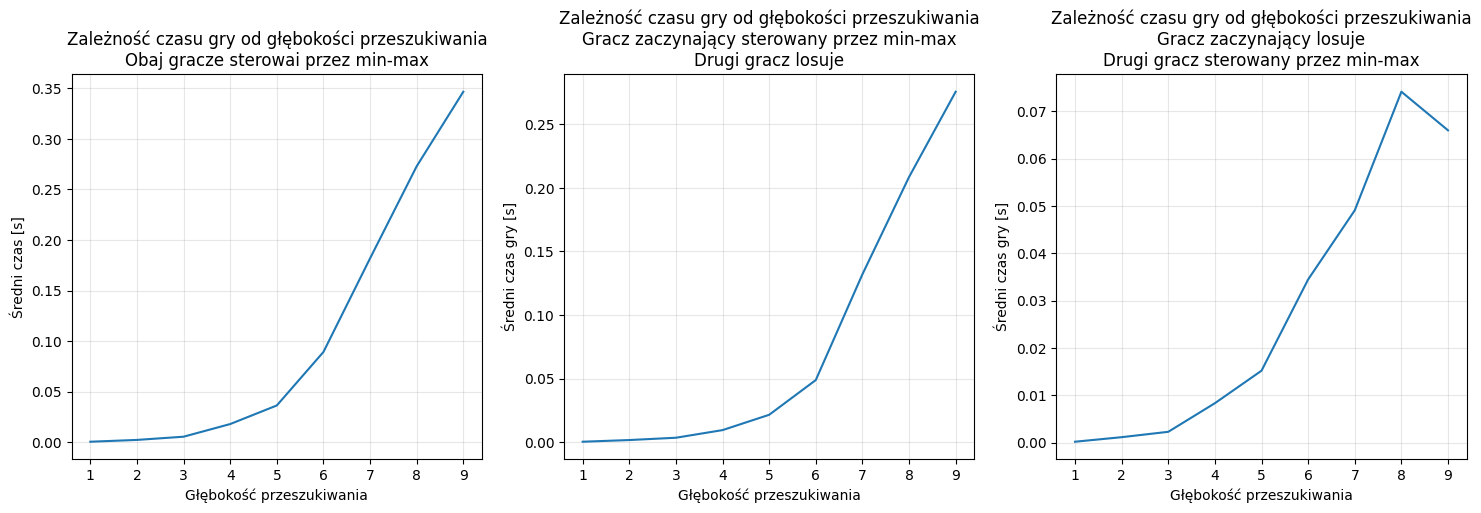

In [37]:
fig = plt.figure(figsize=(18, 5))

ax = fig.add_subplot(1, 3, 1)
ax.plot(depths, [np.mean(res) for res in results_times[0]])
ax.set_xlabel('Głębokość przeszukiwania')
ax.set_ylabel('Średni czas [s]')
ax.grid(alpha=0.3)
ax.set_title('Zależność czasu gry od głębokości przeszukiwania\nObaj gracze sterowai przez min-max')

ax2 = fig.add_subplot(1, 3, 2)
ax2.plot(depths, [np.mean(res) for res in results_times[1]])
ax2.set_xlabel('Głębokość przeszukiwania')
ax2.set_ylabel('Średni czas gry [s]')
ax2.grid(alpha=0.3)
ax2.set_title('Zależność czasu gry od głębokości przeszukiwania\nGracz zaczynający sterowany przez min-max\nDrugi gracz losuje')

ax3 = fig.add_subplot(1, 3, 3)
ax3.plot(depths, [np.mean(res) for res in results_times[2]])
ax3.set_xlabel('Głębokość przeszukiwania')
ax3.set_ylabel('Średni czas gry [s]')
ax3.grid(alpha=0.3)
ax3.set_title('Zależność czasu gry od głębokości przeszukiwania\nGracz zaczynający losuje\nDrugi gracz sterowany przez min-max')

plt.show()

Wyraźnie widać, że czas gry zwiększa się wraz ze zwiększeniem głębokości przeszukiwania rozwiązań. Wynika to z tego, że algorytm musi przwidzieć dla każdego ruchu więcej ruchów do przodu, co zajmuje czas. Idąc tym rozumowaniem, można wywnioskować, że czas wykonania będzie zwiększał się również wraz ze zwiększeniem ilości pól (parametr N).

### **Zależność liczby wykonanych ruchów od głębokości przeszukiwania**

Poniżej tworzę wykresy przedstawiające średnią ilość wykonanych ruchów w zależności od głębokości przeszukiwania rozwiązań dla trzech różnych scenariuszy (obaj gracze sterowani przez algorytm min-max, zaczynający gracz sterowany przez algorytm i drugi gracz losujący ruchy oraz zaczynający gracz losujący ruchy i drugi gracz sterowany przez algorytm):

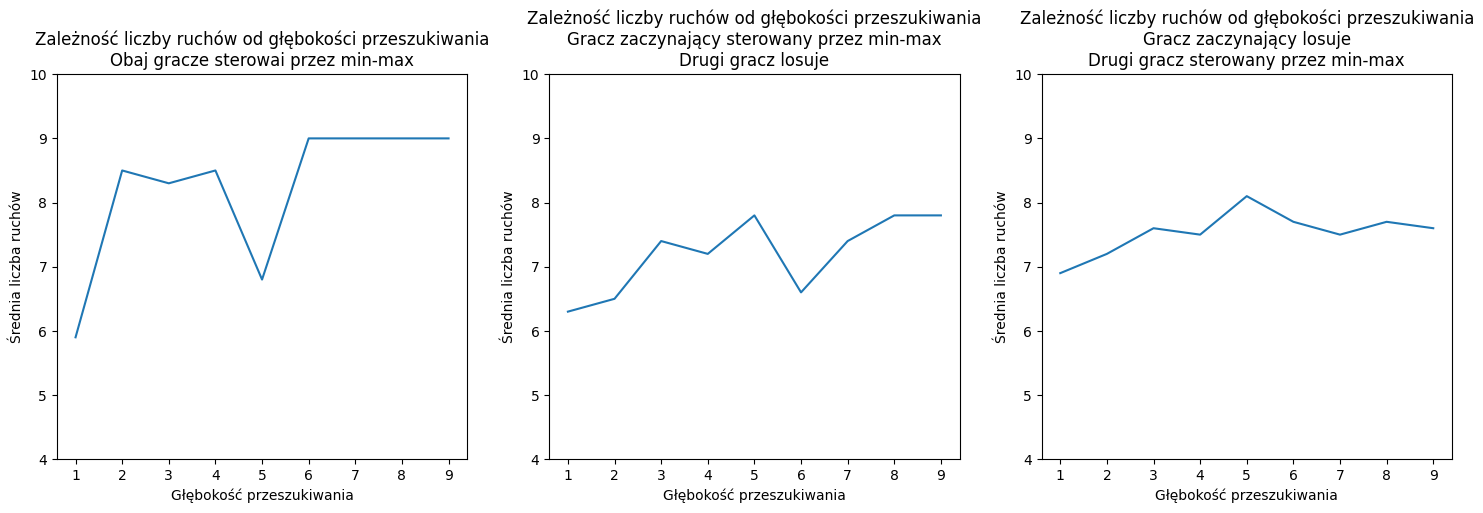

In [40]:
fig = plt.figure(figsize=(18, 5))

ax = fig.add_subplot(1, 3, 1)
ax.plot(depths, [np.mean(res) for res in results_number_of_moves[0]])

ax.set_xlabel('Głębokość przeszukiwania')
ax.set_ylabel('Średnia liczba ruchów')
ax.locator_params(axis='y', integer=True)
ax.set_ylim(bottom=4, top=10)
ax.set_title('Zależność liczby ruchów od głębokości przeszukiwania\nObaj gracze sterowai przez min-max')

ax2 = fig.add_subplot(1, 3, 2)
ax2.plot(depths, [np.mean(res) for res in results_number_of_moves[1]])
ax2.set_xlabel('Głębokość przeszukiwania')
ax2.set_ylabel('Średnia liczba ruchów')
ax2.locator_params(axis='y', integer=True)
ax2.set_ylim(bottom=4, top=10)
ax2.set_title('Zależność liczby ruchów od głębokości przeszukiwania\nGracz zaczynający sterowany przez min-max\nDrugi gracz losuje')

ax3 = fig.add_subplot(1, 3, 3)
ax3.plot(depths, [np.mean(res) for res in results_number_of_moves[2]])
ax3.set_xlabel('Głębokość przeszukiwania')
ax3.set_ylabel('Średnia liczba ruchów')
ax3.locator_params(axis='y', integer=True)
ax3.set_ylim(bottom=4, top=10)
ax3.set_title('Zależność liczby ruchów od głębokości przeszukiwania\nGracz zaczynający losuje\nDrugi gracz sterowany przez min-max')

plt.show()

Wykresy pokazują, że gry, w których obaj gracze są sterowani przez algorytm min-max, rozgrywają się zazwyczaj dłużej od pozostałych scenriuszy. Widać również wzrost średniej liczby wykonywanych ruchów wraz ze wzrostem głębokości przeszukiwania rozwiązań, gdy obaj gracze sterowani są przez algorytm. Można również zauważyć, że gry z zaczynającym graczem losującym swoje ruchy i drugim sterowanym przez min-max trwają około 1 ruch więcej od gier, w których ta kolejność jest odwrócona. Może to wynikać z tego, że w istocie opóźniamy jedynie zwycięstwo gracza kierowanego przez min-max, który ma zdecydowaną przewagę nad losującym.

### **Zależność wyników gry od głębokości przeszukiwania**

Poniżej tworzę wykresy przedstawiające liczbę wygranych gier w zależności od głębokości przeszukiwania rozwiązań dla trzech różnych scenariuszy (obaj gracze sterowani przez algorytm min-max, zaczynający gracz sterowany przez algorytm i drugi gracz losujący ruchy oraz zaczynający gracz losujący ruchy i drugi gracz sterowany przez algorytm):

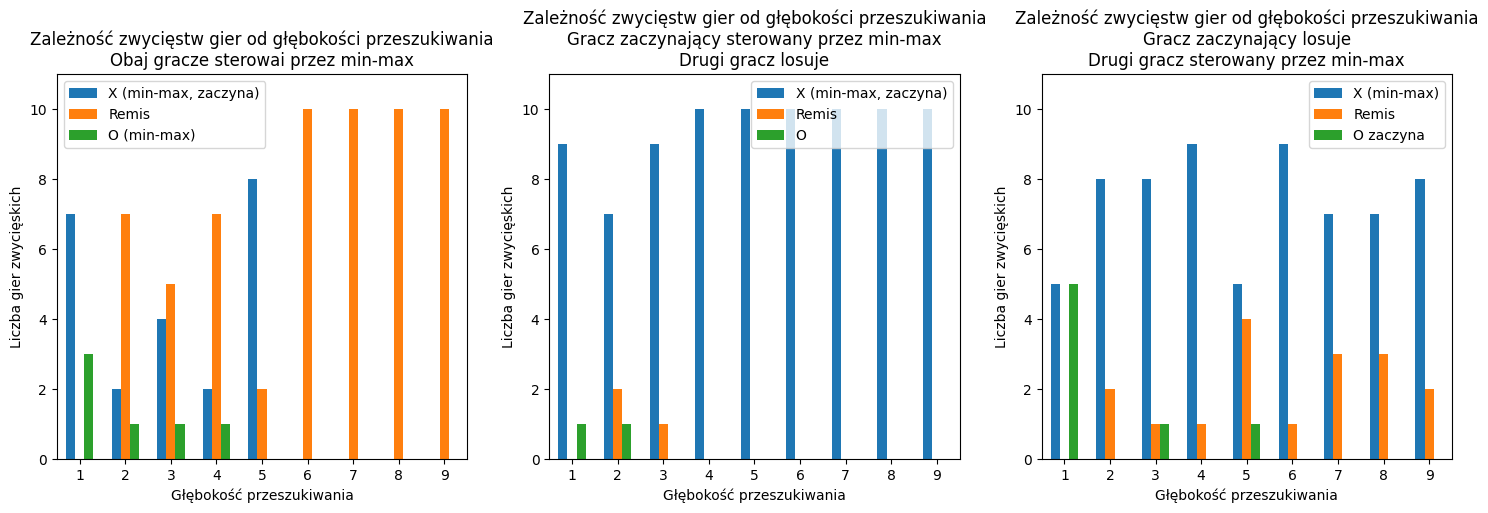

In [44]:
fig = plt.figure(figsize=(18, 5))

ax = fig.add_subplot(1, 3, 1)
ax.bar(np.array(depths)-0.2, [res[1] for res in results_outcomes[0]], width=0.2, label='X (min-max, zaczyna)')
ax.bar(np.array(depths), [res[2] for res in results_outcomes[0]], width=0.2, label='Remis')
ax.bar(np.array(depths)+0.2, [res[0] for res in results_outcomes[0]], width=0.2, label='O (min-max)')
ax.set_xlim(left=0.5, right=9.5)
ax.set_ylim(bottom=0, top=11)
ax.set_xlabel('Głębokość przeszukiwania')
ax.set_ylabel('Liczba gier zwycięskich')
ax.set_title('Zależność zwycięstw gier od głębokości przeszukiwania\nObaj gracze sterowai przez min-max')
ax.legend()

ax2 = fig.add_subplot(1, 3, 2)
ax2.bar(np.array(depths)-0.2, [res[1] for res in results_outcomes[1]], width=0.2, label='X (min-max, zaczyna)')
ax2.bar(np.array(depths), [res[2] for res in results_outcomes[1]], width=0.2, label='Remis')
ax2.bar(np.array(depths)+0.2, [res[0] for res in results_outcomes[1]], width=0.2, label='O')
ax2.set_xlabel('Głębokość przeszukiwania')
ax2.set_xlim(left=0.5, right=9.5)
ax2.set_ylim(bottom=0, top=11)
ax2.set_ylabel('Liczba gier zwycięskich')
ax2.set_title('Zależność zwycięstw gier od głębokości przeszukiwania\nGracz zaczynający sterowany przez min-max\nDrugi gracz losuje')
ax2.legend()

ax3 = fig.add_subplot(1, 3, 3)
ax3.bar(np.array(depths)-0.2, [res[1] for res in results_outcomes[2]], width=0.2, label='X (min-max)')
ax3.bar(np.array(depths), [res[2] for res in results_outcomes[2]], width=0.2, label='Remis')
ax3.bar(np.array(depths)+0.2, [res[0] for res in results_outcomes[2]], width=0.2, label='O zaczyna')
ax3.set_xlabel('Głębokość przeszukiwania')
ax3.set_xlim(left=0.5, right=9.5)
ax3.set_ylim(bottom=0, top=11)
ax3.set_ylabel('Liczba gier zwycięskich')
ax3.set_title('Zależność zwycięstw gier od głębokości przeszukiwania\nGracz zaczynający losuje\nDrugi gracz sterowany przez min-max')
ax3.legend()

plt.show()

Wykresy pokazują, że w przypadku gier, w których obaj gracze sterowani są przez algorytm min-max, dla małych wartości głębokości przeszukiwania rozwiązań gracz rozpoczynający ma przewagę, jednak wraz ze wzrostem głębokości obaj gracze przewidują coraz więcej ruchów do przodu, zatem obaj są w stanie podejmować lepsze decyzje, co ostatecznie prowadzi do wyraźnej przewagi liczby remisów.

Dla gier, w których zaczynającym graczem steruje algorytm min-max, a drugi gracz losuje ruchy, wyraźnie widać przewagę algorytmu min-max. Ta przewaga, choć wciąż wyraźna, zmniejsza się w przypadku w którym kolejność rozpoczynania jest zamieniona - losowe wybieranie ruchów przez gracza zaczynającego prowadzi niekiedy do remisów, a nawet, przy małych wartościach głębokości przeszukiwania rozwiązań, do zwycięstwa losującego przeciwnika. 

Widać przede wszystkim wyraźną zależność - im większa głębokośc przeszukiwania tym lepsze ruchy wykonuje algorytm.